# Insert

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [3]:
import tensorflow as tf

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Import images and transform then into 1D

In [ ]:
resolution = [32,32]
dimension = 3072

trainingList = pd.DataFrame(columns = ['label'])
evaluationList = pd.DataFrame(columns = ['label'])
validateList = pd.DataFrame(columns = ['label'])

for root, dirs, files in os.walk('Food-5K/training', topdown=False):
    for file in files:
        try:
            image = Image.open(root+'/'+file)
            imageResize = tf.image.resize(image, resolution, method='nearest', preserve_aspect_ratio=False)
            imageFlatten = tf.reshape(imageResize, [dimension]).numpy()
            imageFlatten = imageFlatten/255
            trainingList = pd.concat([trainingList, pd.DataFrame(imageFlatten).T], ignore_index=True)
            trainingList.loc[trainingList.shape[0]-1,'label'] = int(file[0])
        except Exception:
            print('Error getting training image on image ' + file)
            
    for root, dirs, files in os.walk('Food-5K/evaluation', topdown=False):
        for file in files:
            try:
                image = Image.open(root+'/'+file)
                imageResize = tf.image.resize(image, resolution, method='nearest', preserve_aspect_ratio=False)
                imageFlatten = tf.reshape(imageResize, [dimension]).numpy()
                imageFlatten = imageFlatten/255
                evaluationList = pd.concat([evaluationList, pd.DataFrame(imageFlatten).T], ignore_index=True)
                evaluationList.loc[evaluationList.shape[0]-1,'label'] = int(file[0])
            except Exception:
                print('Error getting evaluation image on image ' + file)
            
    for root, dirs, files in os.walk('Food-5K/validation', topdown=False):
        for file in files:
            try:
                image = Image.open(root+'/'+file)
                imageResize = tf.image.resize(image, resolution, method='nearest', preserve_aspect_ratio=False)
                imageFlatten = tf.reshape(imageResize, [dimension]).numpy()
                imageFlatten = imageFlatten/255
                validateList = pd.concat([validateList, pd.DataFrame(imageFlatten).T], ignore_index=True)
                validateList.loc[validateList.shape[0]-1,'label'] = int(file[0])
            except Exception:
                print('Error getting testing image on image ' + file)
                

In [ ]:
%store trainingList
%store evaluationList
%store validateList

In [2]:
resolution = [32,32]
dimension = 3072

%store -r trainingList
%store -r evaluationList
%store -r validateList

# BUILDING THE NEURAL NETWORK

In [3]:
import tensorflow as tf

In [31]:
def createFFN(nHiddenLayers, unitsHiddenLayer, kerner_reg, bias_reg, activity_reg, dropoutRate):
    ffn = tf.keras.models.Sequential()
    
    # adding the input layer
    ffn.add(tf.keras.layers.Dense(units=nHiddenLayers,
                                  input_dim=dimension, 
                                  activation='relu',
                                  activity_regularizer=activity_reg,
                                  bias_regularizer= bias_reg,
                                  kernel_regularizer= kerner_reg
                                 ))
    
    ffn.add(tf.keras.layers.Dropout(dropoutRate))
    
    # adding the hidden layers
    for i in range(nHiddenLayers):
            
        ffn.add(tf.keras.layers.Dense(units=unitsHiddenLayer,
                                     activation='relu',
                                     bias_regularizer= bias_reg,
                                     activity_regularizer= activity_reg,
                                     kernel_regularizer= kerner_reg
                                     ))
        ffn.add(tf.keras.layers.Dropout(dropoutRate))
            
        
    # adding the output layer
    ffn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    return ffn

In [43]:
reg = 1e-6

drop = 0.3

ffn = createFFN(nHiddenLayers = 11, unitsHiddenLayer = 26, kerner_reg = tf.keras.regularizers.L1(reg), bias_reg =tf.keras.regularizers.L1(reg), activity_reg = tf.keras.regularizers.L1(reg), dropoutRate = drop)


ffn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
       loss=tf.keras.losses.BinaryCrossentropy(),
       metrics = ['accuracy'])


In [42]:
def train(ffn):
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

    history = ffn.fit(trainingList.drop(['label'], axis=1),
                  trainingList['label'].astype('float'),
                  validation_data = (validateList.drop(['label'], axis=1), validateList['label'].astype('float')),
                  batch_size = 128,
                  epochs = 100,
                  verbose='auto',
                  shuffle = True,
                  callbacks=[es]
                 )
    return history


# Train and test model

In [ ]:
history = train(ffn)

In [8]:
import matplotlib.pyplot as plt

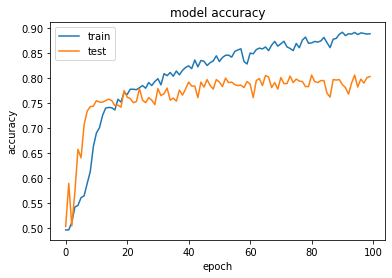

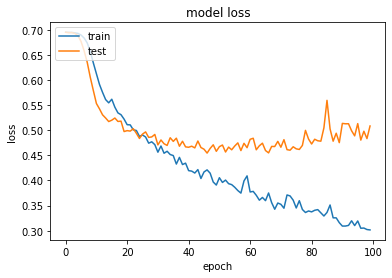

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# TEST AND PLOT

In [169]:
test_loss, test_acc = ffn.evaluate(evaluationList.drop(['label'], axis=1),
                  evaluationList['label'].astype('float'), verbose=2)

32/32 - 0s - loss: 0.4925 - accuracy: 0.7690 - 261ms/epoch - 8ms/step


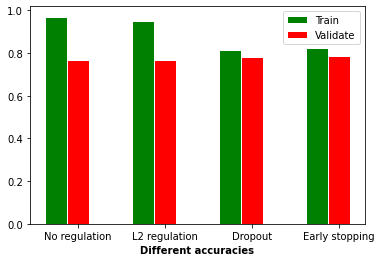

In [138]:
# Print a bar chart with groups

import numpy as np
import matplotlib.pyplot as plt

# set height of bar
# length of these lists determine the number
# of groups (they must all be the same length)
bars1 = [trainNo, trainL2, trainDrop, trainEarly]
bars2 = [valNo, valL2, valDrop, valEarly]

# set width of bar. To work and supply some padding
# the number of groups times barWidth must be
# a little less than 1 (since the next group
# will start at 1, then 2, etc).

barWidth = 0.25
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, bars1, color='green', width=barWidth, edgecolor='white', label='Train')
plt.bar(r2, bars2, color='red', width=barWidth, edgecolor='white', label='Validate')

# Add xticks on the middle of the group bars
plt.xlabel('Different accuracies', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['No regulation', 'L2 regulation', 'Dropout', 'Early stopping'])

# Create legend & Show graphic
plt.legend()
plt.show()
#plt.savefig("barChart.pdf",dpi=400,bbox_inches='tight',pad_inches=0.05) # save as a pdf